## Set-up

Import modules.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Data loading

Download the data.

In [ ]:
!wget https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true

--2021-02-19 12:20:00--  https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz [following]
--2021-02-19 12:20:00--  https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz [following]
--2021-02-19 12:20:01--  https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to ra

Fetch the data.

In [ ]:
!tar -xvf latestdata.tar.gz?raw=true

latestdata.csv


Load the data.

In [ ]:
dataframe = pd.read_csv('latestdata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data viewing

In [ ]:
dataframe.head(5)

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

## Data cleaning and visualisation

Create a copy for exploration.

In [ ]:
df = dataframe.copy()

### Visualise categorical data

In [ ]:
def plot_categorical(col):
  col_count = df[col].value_counts()[:10]
  sns.barplot(x=col_count.index, y=col_count.values)
  plt.title('Frequency Distribution of ' + col)
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel(col)
  plt.xticks(rotation=75)

In [ ]:
cols_lst = list(df.select_dtypes(include=[object]).columns)
cols_lst

['ID',
 'age',
 'sex',
 'city',
 'province',
 'country',
 'geo_resolution',
 'date_onset_symptoms',
 'date_admission_hospital',
 'date_confirmation',
 'symptoms',
 'lives_in_Wuhan',
 'travel_history_dates',
 'travel_history_location',
 'reported_market_exposure',
 'additional_information',
 'chronic_disease',
 'source',
 'sequence_available',
 'outcome',
 'date_death_or_discharge',
 'notes_for_discussion',
 'location',
 'admin3',
 'admin2',
 'admin1',
 'country_new',
 'data_moderator_initials',
 'travel_history_binary']

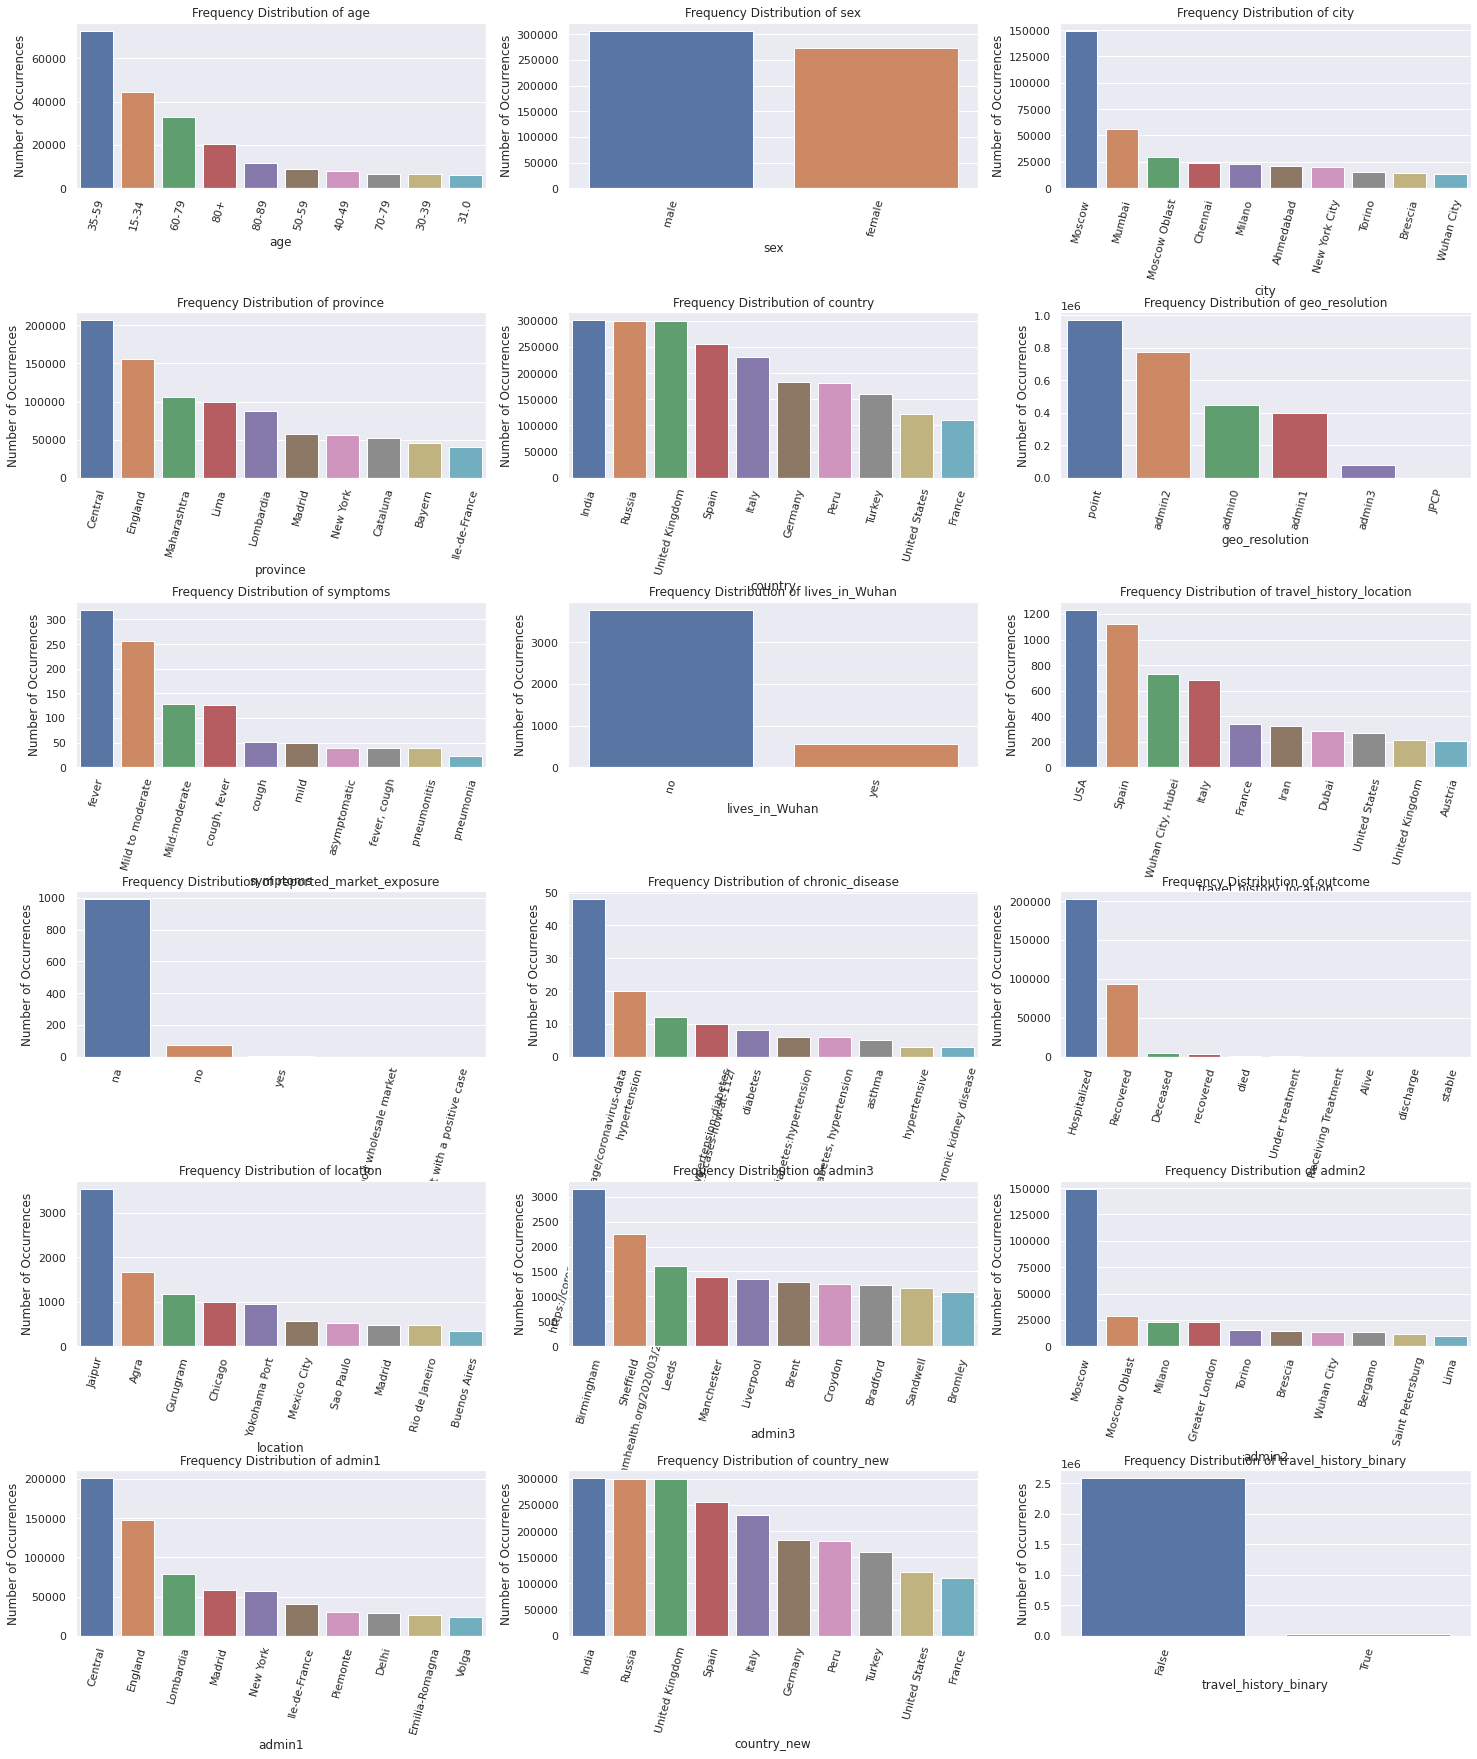

In [113]:
exclude = ['ID', 'date_onset_symptoms', 'date_admission_hospital', 
           'date_confirmation', 'travel_history_dates', 
           'additional_information', 'source', 'sequence_available', 
           'date_death_or_discharge', 'notes_for_discussion',
           'data_moderator_initials']
cols_lst = [col for col in cols_lst if col not in exclude]

n_cols = 3
n_rows = int(len(cols_lst)/n_cols) + 1 
plt.figure(figsize=(25, 5 * n_rows))
plt.tight_layout()

for i, col in enumerate(cols_lst, start=0):
  plt.subplot(n_rows,n_cols,i+1)
  plot_categorical(col)
  plt.subplots_adjust(hspace=0.75)
  

### Plot latitude and longitude

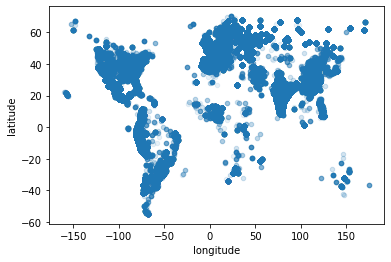

In [ ]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

### Plot number of cases confirmed by time

**date_confirmation** – Date when the reported case was confirmed as having COVID-19 using rt-PCR. Confrmation accuracy is contingent on the data source used. Specifc dates are reported as DD.MM.YYYY.

Inspect 'date_confirmation' column

In [ ]:
df['date_confirmation'].value_counts()

26.03.2020               48319
27.03.2020               43379
23.03.2020               39288
06.05.2020               38679
07.05.2020               38606
                         ...  
12.03.2020-14.03.2020        2
17.01.2020                   2
12.01.2020                   2
16.01.2020                   2
15.01.2020                   2
Name: date_confirmation, Length: 178, dtype: int64

Identify no. entries with missing values

In [ ]:
df.date_confirmation.isnull().sum()

108489

Remove entries with missing values

In [ ]:
len_before = len(df)
print('no. entries before dropping missing values: ', len_before)
df = df.dropna(subset=['date_confirmation'])
len_after  = len(df) 
print('no. entries after dropping missing values:  ', len_after)
print('no. entries dropped:                        ', len_before - len_after)

no. entries before dropping missing values:  2676311
no. entries after dropping missing values:   2567822
no. entries dropped:                         108489


Try to identify entries not in the format 'DD.MM.YYYY'.

In [ ]:
df['date_confirmation'][df.date_confirmation.str.len() != 10]

5556     25.02.2020 - 26.02.2020
12774    25.02.2020 - 26.02.2020
12779    25.02.2020 - 03.03.2020
12780    25.02.2020 - 03.03.2020
12781    25.02.2020 - 03.03.2020
                  ...           
36111    14.03.2020 - 16.03.2020
36112    14.03.2020 - 16.03.2020
36113    14.03.2020 - 16.03.2020
36114    14.03.2020 - 16.03.2020
36115    14.03.2020 - 16.03.2020
Name: date_confirmation, Length: 1975, dtype: object

Deal with entries not in the format 'DD.MM.YYYY'. (I chose to remove them.)

In [ ]:
len_before = len(df)
print('no. entries before dropping wrongly-formatted values: ', len_before)
df = df[df.date_confirmation.str.len() == 10]
len_after  = len(df) 
print('no. entries after dropping wrongly-formatted values:  ', len_after)
print('no. entries dropped:                                  ', len_before - len_after)

Change 'date_confirmation' column data-type to 'datetime'.

In [ ]:
dtype_before = df['date_confirmation'].dtype
print('dtype before: ', dtype_before)
df['date_confirmation'] = pd.to_datetime(df['date_confirmation'])
dtype_after = df['date_confirmation'].dtype
print('dtype after:  ', dtype_after)

Sort cases by date confirmed.

In [ ]:
print('data before sorting:')
print('--------------------')
print(df['date_confirmation'])
df = df.sort_values(by=['date_confirmation'])
print('\n')
print('data after sorting:')
print('--------------------')
print(df['date_confirmation'])

Plot number of cases confirmed by date.

In [ ]:
daycount = df['date_confirmation'].value_counts()
daycount = daycount.sort_index()

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
daycount.plot()
sns.scatterplot(x=daycount.index, y=daycount.values)
plt.suptitle('no. cases confirmed by date')

plt.subplot(1, 2, 2)
plt.xticks([])
daycount.plot(kind='bar')
plt.show()

Investigate behaviour of graph by viewing $n$ entries with the highest frequency.

In [ ]:
n=20
f = df['date_confirmation'].value_counts()[:n].index.tolist()
f

Plot number of cases confirmed by month.

In [ ]:
monthcount = df['date_confirmation'].groupby(df['date_confirmation'].dt.month).agg('count')
print('no. cases by month:')
print('-------------------------')
print(monthcount)
print('\n')
monthcount.plot(kind='bar')
plt.title('no. cases confirmed by month')
plt.show()

Create functions for plotting cases by time.

In [ ]:
def plot_by_date(dataframe, show_title=False, kind='line'):
  dataframe = dataframe.sort_values(by=['date_confirmation'])
  count = dataframe['date_confirmation'].value_counts()
  if kind == 'bar':
    plt.xticks([])
    count.sort_index().plot(kind='bar')
  else:
    count.plot()
    sns.scatterplot(x=count.index, y=count.values)
  if show_title:
    plt.title('no. cases confirmed by date')

def plot_by_month(dataframe, kind='bar'):
  count = dataframe['date_confirmation'].groupby(dataframe['date_confirmation'].dt.month).agg('count')
  count.plot(kind=kind)
  plt.title('no. cases confirmed by month')

def plot_by_week(dataframe, kind='bar'):
  count = dataframe['date_confirmation'].groupby(dataframe['date_confirmation'].dt.isocalendar().week).agg('count')
  count.plot(kind=kind)
  plt.title('no. cases confirmed by week')

### Plot number of cases confirmed by country

**country** – Name of country in which the case is reported. Note that imported cases will be assigned to the country in which confrmation occurred - this is typically in the arrival country, rather than the site of infection. “Travel_history_location” will describe other locations of travel for such instances.

**country_new** – Administrative unit level 0 (e.g., country) of where the case was reported.

Inspect 'country' and 'country_new' columns.


In [ ]:
print('country counts:')
print('---------------')
print(df['country'].value_counts())
print('\n')
print('country_new counts:')
print('-------------------')
print(df['country_new'].value_counts())

country counts:
---------------
India                               301207
Russia                              299568
United Kingdom                      299469
Spain                               255108
Italy                               231006
                                     ...  
Gibraltar                                1
Saint Vincent and the Grenadines         1
Lithuania                                1
Liechtenstein                            1
Andorra                                  1
Name: country, Length: 146, dtype: int64


country_new counts:
-------------------
India                               301207
Russia                              299568
United Kingdom                      299469
Spain                               255108
Italy                               231006
                                     ...  
Andorra                                  1
Malta                                    1
Saint Vincent and the Grenadines         1
Gibraltar                

Drop 'country_new' column because it is near-identical to 'country'.

In [ ]:
len_before = len(df.columns)
print('df len before dropping column: ', len_before)
df = df.drop(columns='country_new')
len_after = len(df.columns)
print('df len after dropping column:  ', len_after)

df len before dropping column:  33
df len after dropping column:   32


Identify no. entries with missing values

In [ ]:
print('no. entries with missing values:', df.country.isnull().sum())

no. entries with missing values: 55


Remove entries with missing values.

In [ ]:
len_before = len(df)
print('no. entries before dropping missing values: ', len_before)
df = df.dropna(subset=['country'])
len_after  = len(df) 
print('no. entries after dropping missing values:  ', len_after)
print('no. entries dropped:                        ', len_before - len_after)

no. entries before dropping missing values:  2565847
no. entries after dropping missing values:   2565792
no. entries dropped:                         55


Create new dataframe for data in India.

In [ ]:
df_India = df[df['country'] == 'India']
len(df_India['country'])

301207

Plot number of cases confirmed in India by date.

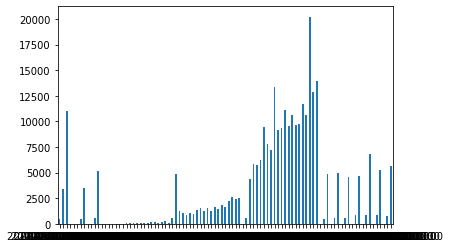

In [ ]:
plot_by_date(df_India, kind='bar')

Plot number of cases confirmed in India by month.

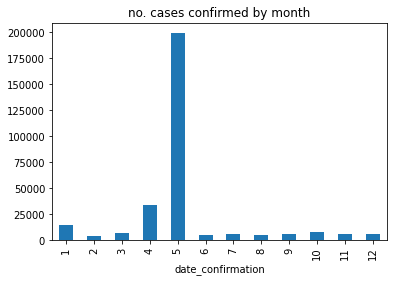

In [ ]:
plot_by_month(df_India)

Create function to plot number of cases confirmed in a country by date.

In [ ]:
def plot_by_country(dataframe, country, kind='line'):
  dataframe = dataframe[dataframe['country'] == country]
  plot_by_date(dataframe, kind=kind)

### Plot number of cases confirmed by country for selected countries

Obtain list of unique countries.

In [ ]:
countries = df['country'].unique()
print('no. unique countries: ', len(countries))
print(countries)

no. unique countries:  146
['China' 'Philippines' 'United Arab Emirates' 'Japan' 'Australia'
 'Singapore' 'United States' 'South Korea' 'Iran' 'Ecuador' 'Qatar'
 'Switzerland' 'Kuwait' 'Italy' 'Canada' 'Israel' 'Germany' 'Armenia'
 'Bahrain' 'Egypt' 'United Kingdom' 'Luxembourg' 'Finland' 'Belgium'
 'Croatia' 'Norway' 'Czech Republic' 'Austria' 'Netherlands' 'Iceland'
 'Sweden' 'Spain' 'Turkey' 'Ukraine' 'Nigeria' 'Montenegro' 'India'
 'Bosnia and Herzegovina' 'Colombia' 'Peru' 'Hungary' 'Serbia' 'Albania'
 'Slovakia' 'Argentina' 'Russia' 'Kenya' 'Algeria' 'Slovenia' 'Moldova'
 'Paraguay' 'Estonia' 'South Africa' 'Ireland' 'Mexico' 'Cuba' 'Uruguay'
 'North Macedonia' 'Guatemala' 'Ghana' 'Bahamas' 'Ethiopia' 'Belarus'
 'Thailand' 'Vietnam' 'Nepal' 'France' 'Malaysia' 'Sri Lanka' 'Cambodia'
 'Iraq' 'Tunisia' 'Jordan' 'Senegal' 'Morocco' 'Lebanon' 'Portugal'
 'Brazil' 'Latvia' 'Saudi Arabia' 'Andorra' 'Pakistan' 'Liechtenstein'
 'Niger' 'Zimbabwe' 'Afghanistan' 'Oman' 'Romania' 'Georgia' 

Plot number of cases confirmed by country for selected countries.

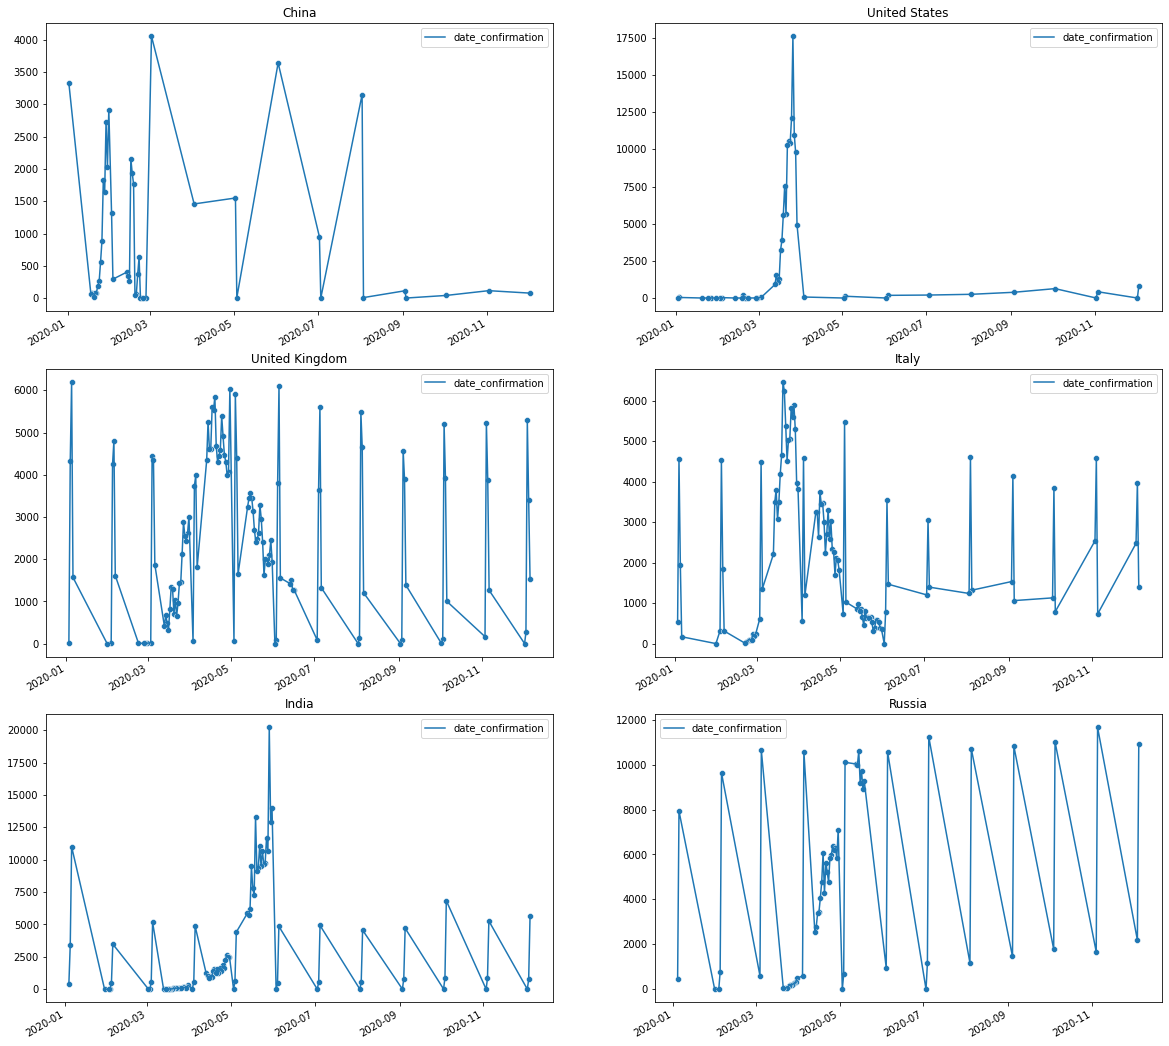

In [ ]:
plt.figure(figsize=(20,20))
for i, country in enumerate(['China', 'United States', 'United Kingdom', 'Italy', 'India', 'Russia']):
  plt.subplot(3,2,i+1)
  plot_by_country(df, country, kind='bar')
  plt.title(country)

### Plot number cases confirmed by age range (unfinished)

Inspect 'age' column.

In [ ]:
df['age'].value_counts()[:20]

35-59    72775
15-34    44573
60-79    33074
80+      20203
80-89    11469
50-59     9001
40-49     7696
70-79     6676
30-39     6306
31.0      6095
60-69     6049
90+       5972
32.0      5890
33.0      5691
30.0      5659
29.0      5656
37.0      5647
35.0      5639
28.0      5595
38.0      5554
Name: age, dtype: int64

Run tests before cleaning.

In [ ]:
print(len(df[df['age'] == '16-80']))
a = df['age'][407242]
print(a, a.isnumeric())
b = df['age'][14442]
print(b, b.isnumeric())
print(a[:2] == '16')
print(b[:2] == '44')
c = 32
print(b in [44])
d = 3.0
# print(d.isnumeric()) -- returns AttributeError: 'float' object has no attribute 'isnumeric'
print(isinstance(a, str))

print('before replacement: ', b)
# df['age'][14442] = '44' -- returns A value is trying to be set on a copy of a slice from a DataFrame
df.at[14442, 'age'] = '35-59'
print('after replacement:  ', df['age'][14442])

68
16-80 False
44 True
True
True
False
True
before replacement:  44
after replacement:   35-59


Clean 'age' data so that they fall under one of: `0-14`, `15-34`, `35-59`, `60-79`, or `80+`.

In [ ]:
for item, frame in df['age'].iteritems():
  if pd.notnull(frame) and str(frame).isnumeric():
    i = int(frame)
    if i < 15:
      # print(item, frame, '0-14')
      df.at[item, 'age'] = '0-14'
      # print(item, df['age'][item])
    elif i < 35:
      # print(item, frame, '15-34')
      df.at[item, 'age'] = '15-34'
      # print(item, df['age'][item])
    elif i < 60:
      # print(item, frame, '35-59')
      df.at[item, 'age'] = '35-59'
      # print(item, df['age'][item])
    elif i < 80:
      # print(item, frame, '60-79')
      df.at[item, 'age'] = '60-79'
      # print(item, df['age'][item])
    else:
      # print(item, frame, '80+')
      df.at[item, 'age'] = '80+'
      # print(item, df['age'][item])
  elif pd.notnull(frame) and 'month' in str(frame):
    print(item, frame)

614363 18 months
614508 18 month
614514 7 months
614565 4 months
614975 13 month
614976 18 month
614985 5 months
615131 8 month
615340 6 months
615448 9 month
615465 5 month
615569 8 month
615946 11 month


In [ ]:
df['age'].value_counts()

35-59      118465
15-34       79807
60-79       48781
80+         22695
80-89       11469
            ...  
6 weeks         1
30-60           1
11-12           1
15-88           1
22-23           1
Name: age, Length: 285, dtype: int64

## Model selection (unfinished)

Create Polynomial Linear Regression model

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

Try on 'monthcount' data.

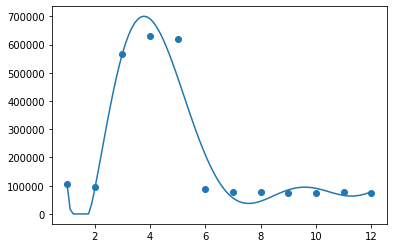

In [ ]:
x=np.array(monthcount.index).reshape(-1, 1)
y=np.array(monthcount.values).reshape(-1, 1)
poly_model.fit(x, y)
xfit=np.linspace(1, 12, 100)
yfit = poly_model.predict(xfit[:, np.newaxis])
for i, yhat in enumerate(yfit):
  if yhat < 0:
    yfit[i] = 0
plt.scatter(x, y)
plt.plot(xfit, yfit);

Try on 'daycount' data

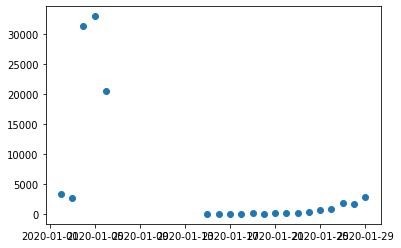

In [ ]:
n=20
x=np.array(daycount[:n].index).reshape(-1, 1)
y=np.array(daycount[:n].values).reshape(-1, 1)
poly_model.fit(x, y)
plt.scatter(x, y)

plt.show()

In [ ]:
start = x[0][0]
print(start)
end = x[-1][0]
print(end)
diff = end - start
diff = diff.astype('timedelta64[D]')
diff = diff.astype(int)
range = pd.date_range(start=start, end=end, periods=diff)
range

2020-01-02T00:00:00.000000000
2020-01-29T00:00:00.000000000


DatetimeIndex([          '2020-01-02 00:00:00',
               '2020-01-03 00:55:23.076923076',
               '2020-01-04 01:50:46.153846153',
               '2020-01-05 02:46:09.230769230',
               '2020-01-06 03:41:32.307692307',
               '2020-01-07 04:36:55.384615384',
               '2020-01-08 05:32:18.461538461',
               '2020-01-09 06:27:41.538461538',
               '2020-01-10 07:23:04.615384615',
               '2020-01-11 08:18:27.692307692',
               '2020-01-12 09:13:50.769230769',
               '2020-01-13 10:09:13.846153846',
               '2020-01-14 11:04:36.923076923',
                         '2020-01-15 12:00:00',
               '2020-01-16 12:55:23.076923077',
               '2020-01-17 13:50:46.153846153',
               '2020-01-18 14:46:09.230769230',
               '2020-01-19 15:41:32.307692307',
               '2020-01-20 16:36:55.384615384',
               '2020-01-21 17:32:18.461538461',
               '2020-01-22 18:27:41.5384

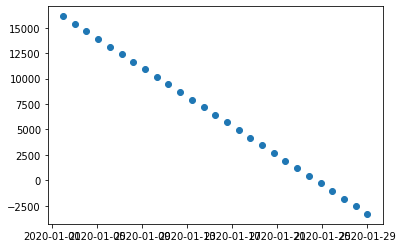

In [ ]:
start = x[0][0]
end = x[-1][0]
diff = end - start
diff = diff.astype('timedelta64[D]')
diff = diff.astype(int)
range = pd.date_range(start=start, end=end, periods=diff)
xfit = np.array(range).reshape(-1, 1)
yfit = poly_model.predict(xfit.reshape(-1, 1))
plt.scatter(xfit, yfit)